### ***Importing Libs***

In [1]:
import os
import time
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.python.client import device_lib
from tensorflow.python.ops.numpy_ops import np_config
        

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
filePath = '/content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip'

In [3]:
!mkdir gcImages

In [ ]:
!unzip /content/drive/MyDrive/Datasets/GCScrapped/gc-dataset.zip -d /content/gcImages

### ***Setting the local GPU***

In [5]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13493723459340884290
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10085661228663054731
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
tf.debugging.set_log_device_placement(False)

In [7]:
dataset_path = '/content/gcImages/content/gc-dataset'
imgDirPath = '/content/gcImages/content/gc-dataset/train'
osSep = '/'
dataPath = imgDirPath + osSep + '*.jpg'

In [8]:
# image attr
img_w = 256
img_h = 256

In [9]:
np_config.enable_numpy_behavior()

#### Model Variables

In [52]:
# model variables
input_shape = (img_w,img_h,1)           # input shape of the nn
num_epochs = 500                    # no of epochs to train  the model
latent_shape = (32,32,256)            # shape of latent space / bottleneck from the VGG
_lw = latent_shape[0]
_lh = latent_shape[1]
_lc = latent_shape[2]
_featureInputShape = (299,299,3)

_featureChannel = 1000

embed_shape = (32,32,1000)

# instantiate the optimizers function
optimizer_fn = keras.optimizers.adam_v2.Adam()

# instantiate the loss function
loss_fn = keras.losses.MeanSquaredError()   

# metrices for train and val accuracy 

train_acc_metric = keras.metrics.MeanSquaredError()
val_acc_metric = keras.metrics.MeanSquaredError()

# var for recording the losses and the accuracy while training and validating
train_loss = []
val_loss = []
train_acc = []
val_acc = []


modelFileName = 'TestMultipathAE100_500'
#  defining the model save / load path 
model_path = '/content/drive/MyDrive/Image Colorization/model-history/model/' + modelFileName + '.model'

# defining the history of model save / load path
history_path = '/content/drive/MyDrive/Image Colorization/model-history/history/' + modelFileName + '.csv'

### ***Setting the Classes***

#### Class to Clean the Dataset

In [11]:
class DatasetCleaner:
    
    '''
    Description : Class to Clean the Datasets
    '''

    # Method to remove the grayscale images from the directroy
    @staticmethod
    def removeGrayScaleFromDir(dirPath, osSep='/', fileType='*.jpg'):
        '''
        Description : 
                Method to remove any grayScale images from the directroy
        Input : 
                dirPath => Path to the image directory (dType - String)
                osSep => OS File Separator (dType - String | Defualt : backslash)
                fileType => Types of Images to read from the directory(dType - String | Default : '*.jpg') 	
        Returns : 
                List (Details of the files removed from the directory)
        '''

        print('Removing any grayScale Images from the directory.........')
        removedFileNames = []
        for id, fileName in enumerate(glob.glob(dirPath + osSep + fileType)):

            image = tf.io.read_file(fileName)
            image = tf.image.decode_jpeg(image)

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False

            if isGrayScale:
                print(f'Removing ## ID : {id} ==== ImageShape : {image.shape} ==== FileName : {fileName}')
                removedFileNames.append([id, image.shape, fileName])
                os.remove(fileName)

        return removedFileNames

    
    # Method to remove the grayScale images from the numpy array
    @staticmethod
    def removeGrayScaleFromNumpy(numpyArr):
        '''
        Description : 
                Method to remove any grayScale images from the numpy.array
        Input : 
                numpyArr => numpy.array consisting of images
        Returns : 
                numpy.array (Consisting of only RGB images)
                List (Details of the images removed from the numpy)
        '''
        removedImages = []

        for id, image in enumerate(numpyArr):

            isGrayScale = True

            if len(image.shape) == 3 and image.shape[2] == 3:
                isGrayScale = False
                r = image[:,:,0]
                g = image[:,:,1]
                b = image[:,:,2]
                
                w = image.shape[0]
                h = image.shape[1]
                isGrayScale = False
                for i in range(w):
                    for j in range(h):
                        
                        if r[i,j] == g[i,j] == b[i,j]:
                            isGrayScale = True
                        else:
                            isGrayScale = False
                            break
            else:
                isGrayScale = True

            if isGrayScale:
                print(f'GrayScale Found ## ID : {id} ==== ImageShape : {image.shape}')
                removedImages.append([id, image.shape])
        print(removedImages)
        print('Removing any grayScale Images from the numpy.array.........')
        numpyArr = np.delete(numpyArr, [dtl[0] for dtl in removedImages], axis=0)

        return numpyArr, removedImages
    

#### Class to Load the Dataset

In [12]:
class DatasetLoader:
    '''
    Description : Class to load the Dataset
    '''

    # Method to load the dataset from the dir
    @staticmethod
    def loadDataSetFromDir(imageDataPath, isShuffle = False):
        '''
        Description : 
                Method to load the dataset from the directory
        Input :
                imageDataPath => Path to the directory where the images are located (dType - String)
                isShuffle => If the images in the dataset to be shuffled (Default - False)
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.list_files(imageDataPath, shuffle=isShuffle)
    
    # Method to load the dataset from the numpy.array
    @staticmethod
    def loadDataSetFromNumpy(numpyArr):
        '''
        Description : 
                Method to load the dataset from the numpy
        Input :
                numpyArr => numpy.array containing the data 
        Returns :
                TensorSliceDataset 
        '''
        return tf.data.Dataset.from_tensor_slices(numpyArr)

#### ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB

In [13]:
class ImageUtils:

    '''
    Description : ImageUtils class to get the RGB, LAB and to split the LAB channel into L and AB
    '''

    # Method to get the RGB images
    @staticmethod
    def getRGBData(filePath, img_width, img_height):
        '''
        Description : 
                Method to get the RGB image from the given path
        Input :
                filePath => File path to the image (dType - String)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                numpy.array 
        '''
        filePath = filePath.numpy().decode('utf-8')
        image = imread(filePath)
        image = resize(image, output_shape=[img_width, img_height])         
        # resize method gives resized image along with normalization
        return image

    # Method to get the LAB images
    @staticmethod
    def getLABData(image):
        '''
        Description : 
                Method to get the LAB image from the given image
        Input :
                image => RGB Image 
        Returns :
                numpy.array
        '''
        labImage = rgb2lab(image)
        return labImage


    # # Method to get the training data
    # def getTrainingData(filePath):

    #     image = tf.io.read_file(filePath)
    #     image = tf.io.decode_jpeg(image)
    #     image = tf.image.convert_image_dtype(image, tf.float32)

    #     labImage = tfio.experimental.color.rgb_to_lab(image)

    #     return tf.reshape(labImage[:,:,0], shape=[256,256,1]), labImage[:,:,1:]


    # Method to get the X(L) and Y(AB) data
    @staticmethod
    def getXYData(labImage, img_width, img_height):
        '''
        Description : 
                Method to split LAB image into L and AB channels as X and Y
        Input :
                labImage => LAB Image
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                tf.Tensor, tf.Tensor 
        '''
        _l = tf.reshape(labImage[:,:,0], shape=[img_width,img_height,1])
        _ab = tf.reshape(labImage[:,:,1:] / 128, shape=[img_width,img_height,2])
        return _l, _ab

    # to fix the shape
    @staticmethod
    def fixup_shape(_l, _ab, w, h):

        '''
        Description : 
                Method to fix the shape of L and AB channels i.e X and Y
        Input :
                _l => L channel
                _ab => AB channel
                w => Width of the Image 
                h => Height of the Image
        Returns :
                tf.Tensor (shape => (w,h,1)), tf.Tensor (shape => (w,h,2))
        '''

        _l.set_shape([w, h, 1])
        _ab.set_shape([w, h, 2])
        return _l, _ab

#### Mapper class to Map the given Dataset

In [14]:
class DatasetMapper:

    '''
    Description : Mapper class to map the given dataset
    '''

    # Method to get the only RGB image Dataset from the give Image File Name Dataset
    @staticmethod
    def getRGBDataset(imgFileNames_ds, img_width, img_height):
        '''
        Description : 
                Method to get the only RGB image Dataset from the give Image File Name Dataset
        Input :
                imgFileNames_ds => TensorSliceDataset (consist of the image file names)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset Shapes: (img_width, img_height, None), types: tf.float32
        '''
        return imgFileNames_ds.map(lambda x : tf.py_function(ImageUtils.getRGBData, 
                                                             [x, img_width, img_height], 
                                                             tf.float32))

    # Method to get the only LAB images from the RGB image dataset
    @staticmethod
    def getLABDataset(rgbImg_ds):
        '''
        Description : 
                Method to get the only LAB images from the RGB image dataset
        Input :
                rgbImg_ds => MapDatset (consist of the RGB images)
            
        Returns :
                MapDataset Shapes: (rgbImg_width, rgbImg_height, None), types: tf.float32
        '''
        return rgbImg_ds.map(lambda x : tf.py_function(ImageUtils.getLABData,
                                                       [x],
                                                       tf.float32))

    # Method to split the LAB Image into L(X) and AB(Y) channels
    @staticmethod
    def getXYDataset(labImg_ds, img_width, img_height):
        '''
        Description : 
                Method to split the LAB Image into L(X) and AB(Y) channels
        Input :
                labImage => MapDatset (consist of the LAB images)
                img_width => Width of the Image 
                img_height => Height of the Image
        Returns :
                MapDataset shapes: ((img_width, img_height, 1), (img_width, img_height, 2)), types: (tf.float32, tf.float32)
        '''

        ds = labImg_ds.map(lambda x : tf.py_function(ImageUtils.getXYData,
                                                       [x, img_width, img_height],
                                                       [tf.float32, tf.float32]))

        return ds.map(lambda x, y : ImageUtils.fixup_shape(x, y, img_width, img_height))

### ***Loading GCScrapped 100 Images datasets***

In [15]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files : {total_files}')

Total JPG Files : 8800


### Removing the any Grayscale Images from the dir

In [16]:
rmFileList = DatasetCleaner.removeGrayScaleFromDir(imgDirPath)
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')
print(f'Total Count of the removed grayScale images : {len(rmFileList)}')    

Removing any grayScale Images from the directory.........
Removing ## ID : 244 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/4423.jpg
Removing ## ID : 717 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/2897.jpg
Removing ## ID : 2504 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/6849.jpg
Removing ## ID : 2608 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/5410.jpg
Removing ## ID : 3130 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/4705.jpg
Removing ## ID : 3587 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8689.jpg
Removing ## ID : 3860 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/content/gc-dataset/train/8679.jpg
Removing ## ID : 4867 ==== ImageShape : (256, 256, 1) ==== FileName : /content/gcImages/co

In [17]:
total_files = len(glob.glob(imgDirPath + osSep + '*.jpg'))
print(f'Total JPG Files in the Directroy : {total_files}')

Total JPG Files in the Directroy : 8785


In [18]:
# reading the all images from the folder
image_ds = DatasetLoader.loadDataSetFromDir(dataPath).take(100)

In [19]:
# displaying the first three data Tensors
for data in image_ds.take(2):
    print(data)

tf.Tensor(b'/content/gcImages/content/gc-dataset/train/0.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1.jpg', shape=(), dtype=string)


#### No of Images in the Dataset

In [20]:
total_imgs = len(image_ds)
print(f'Size of image_ds : {total_imgs}')

Size of image_ds : 100


#### Setting the train-test-validation dataset size

In [21]:
train_size = int(total_imgs * 0.8)
val_size = int(total_imgs * 0.1)
test_size = int(total_imgs - train_size - val_size)
print(f'Train Size : {train_size}')
print(f'Test Size : {test_size}')
print(f'Val Size : {val_size}')

Train Size : 80
Test Size : 10
Val Size : 10


#### Splitting into train-test-validation

In [22]:
# taking the train-test-val data
train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size + val_size)

In [23]:
print(f'train_ds Size : {len(train_ds)}')
print(f'val_ds Size : {len(val_ds)}')
print(f'test_ds Size : {len(test_ds)}')

train_ds Size : 80
val_ds Size : 10
test_ds Size : 10


In [24]:
# getting the RGB Images dataset from the Original Dataset
train_rgb_ds = DatasetMapper.getRGBDataset(train_ds, img_w, img_h)

In [25]:
# getting the LAB Images dataset from the collected RGB Dataset
train_lab_ds = DatasetMapper.getLABDataset(train_rgb_ds)

In [26]:
# getting the data to train model i.e L(X) & AB(Y) channels from the collected LAB Dataset
trainData = DatasetMapper.getXYDataset(train_lab_ds, img_w, img_h)

In [27]:
# getting the RGB Images dataset from the testing Dataset
test_rgb_ds = DatasetMapper.getRGBDataset(test_ds, img_w, img_h)

In [28]:
# getting the LAB Images dataset from the collected testing RGB Dataset
test_lab_ds = DatasetMapper.getLABDataset(test_rgb_ds)

In [29]:
# getting the data to test model i.e L(X) & AB(Y) channels from the collected LAB Dataset
testData = DatasetMapper.getXYDataset(test_lab_ds, img_w, img_h)

In [30]:
# getting the RGB Images dataset from the Original Validation Dataset
val_rgb_ds = DatasetMapper.getRGBDataset(val_ds, img_w, img_h)

In [31]:
# getting the LAB Images dataset from the collected Validation RGB Dataset
val_lab_ds = DatasetMapper.getLABDataset(val_rgb_ds)

In [32]:
# getting the data to validate model i.e L(X) & AB(Y) channels from the collected LAB Dataset
valData = DatasetMapper.getXYDataset(val_lab_ds, img_w, img_h)

Np Conversion

In [33]:
# taking data in np format for train
Xtrain = []
ytrain = []
for data in trainData:
    Xtrain.append(data[0].numpy())
    ytrain.append(data[1].numpy())
Xtrain = np.asarray(Xtrain)
ytrain = np.asarray(ytrain)

In [34]:
print(Xtrain.shape)
print(ytrain.shape)

(80, 256, 256, 1)
(80, 256, 256, 2)


In [35]:
# taking data in np format for val
Xval = []
yval = []
for data in valData:
    Xval.append(data[0].numpy())
    yval.append(data[1].numpy())
Xval = np.asarray(Xval)
yval = np.asarray(yval)

In [36]:
print(Xval.shape)
print(yval.shape)

(10, 256, 256, 1)
(10, 256, 256, 2)


In [37]:
# taking data in np format for test
Xtest = []
ytest = []
for data in testData:
    Xtest.append(data[0].numpy())
    ytest.append(data[1].numpy())
Xtest = np.asarray(Xtest)
ytest = np.asarray(ytest)

In [38]:
print(Xtest.shape)
print(ytest.shape)

(10, 256, 256, 1)
(10, 256, 256, 2)


### ***InceptionNet***

In [39]:
inceptionNet = InceptionResNetV2(weights='imagenet', input_shape=(299,299,3),include_top=True)

225222656/225209952 [==============================] - 2s 0us/step


In [40]:
def getFeatureDataFromResNet(_l):
        
        inceptionInput = resize(_l[:,:,0], output_shape=(299,299,3))
        # print(inceptionInput.shape)
        inceptionInput = inceptionInput.reshape((1,) + inceptionInput.shape)
        # print(inceptionInput.shape)
        # predicting the features
        _features = inceptionNet.predict(inceptionInput)
        # print(_features.shape)

        fusion_output = RepeatVector(32 * 32)(_features)
        fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
        # print(fusion_output)
        return fusion_output[0]

In [41]:
XtrainEmbed = [getFeatureDataFromResNet(_l) for _l in Xtrain]

In [42]:
XtrainEmbed = np.asarray(XtrainEmbed)

In [43]:
XtrainEmbed.shape

(80, 32, 32, 1000)

In [44]:
XvalEmbed = [getFeatureDataFromResNet(_l) for _l in Xval]

In [45]:
XvalEmbed = np.asarray(XvalEmbed)

In [46]:
XvalEmbed.shape

(10, 32, 32, 1000)

### ***Creating the Autoencoder Model***

In [47]:
def autoEncoder(inputShape=input_shape, featureShape=embed_shape):

    # input layer
    input_L = Input(shape = inputShape)

    # embed input layer
    embed_L = Input(shape = embed_shape)

    # encoder

    # l1 
    l1 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same',strides=2)(input_L)

    # l2
    l2 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l1)

    # l3
    l3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', strides=2)(l2)

    # l4
    l4 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(l3)

    # l5
    l5 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', strides=2)(l4)

    # l6
    l6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(l5)

    # l7
    l7 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(l6)

    # l8
    l8 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(l7)

    # fusion Layer
    fusion_output = concatenate([l8, embed_L], axis=3)
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)

    # # decoder

    # l9
    l9 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(fusion_output)
    l9_up = UpSampling2D((2,2))(l9)

    # l10
    l10 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l9_up)
    l10_up = UpSampling2D((2,2))(l10)

    # l11
    l11 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l10_up)

    # l12
    l12 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l11)

    # l13
    l13 = Conv2D(filters=2, kernel_size=(3,3), activation='tanh', padding='same')(l12)
    l13_up = UpSampling2D((2,2))(l13)

    return Model(inputs=[input_L,embed_L], outputs=l13_up)

In [48]:
ae = autoEncoder()

In [49]:
ae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
ae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 128, 128, 12  73856       ['conv2d_203[0][0]']             
                                8)                                                            

### ***Visualizing the Performance***


In [50]:
def visualizeHistory(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### ***Training the Model***

Epoch 1/500
2/2 [==============================] - 2s 1s/step - loss: 0.0125 - accuracy: 0.3367 - val_loss: 0.0155 - val_accuracy: 0.3278
Epoch 2/500
2/2 [==============================] - 2s 938ms/step - loss: 0.0122 - accuracy: 0.3399 - val_loss: 0.0155 - val_accuracy: 0.3286
Epoch 3/500
2/2 [==============================] - 2s 949ms/step - loss: 0.0122 - accuracy: 0.3419 - val_loss: 0.0152 - val_accuracy: 0.3306
Epoch 4/500
2/2 [==============================] - 2s 936ms/step - loss: 0.0120 - accuracy: 0.3442 - val_loss: 0.0151 - val_accuracy: 0.3311
Epoch 5/500
2/2 [==============================] - 2s 930ms/step - loss: 0.0120 - accuracy: 0.3441 - val_loss: 0.0152 - val_accuracy: 0.3304
Epoch 6/500
2/2 [==============================] - 2s 922ms/step - loss: 0.0119 - accuracy: 0.3444 - val_loss: 0.0150 - val_accuracy: 0.3321
Epoch 7/500
2/2 [==============================] - 2s 908ms/step - loss: 0.0118 - accuracy: 0.3442 - val_loss: 0.0149 - val_accuracy: 0.3350
Epoch 8/500
2/2 

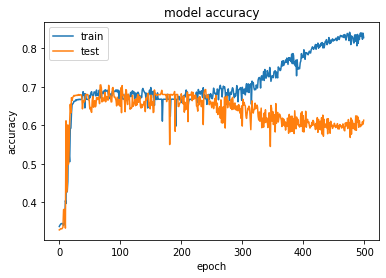

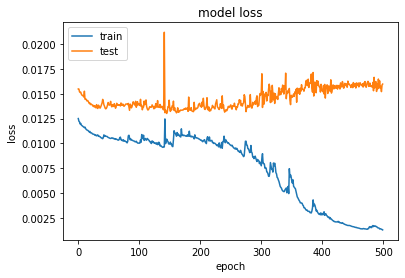

In [53]:
# training the model
history = ae.fit([Xtrain, XtrainEmbed], ytrain, validation_split=0.2, epochs=num_epochs, batch_size=32)
# ae.save(model_path)

# convert the history.history dict to a pandas Dat  aFrame:     
# hist_df = pd.DataFrame(history.history) 
# with open(hist_csv_file, mode='w') as f:
    # hist_df.to_csv(f)
visualizeHistory(history)

### ***Predicting the Results***

In [ ]:
ae.save(model_path)


In [55]:

# convert the history.history dict to a pandas Dat  aFrame:     
hist_df = pd.DataFrame(history.history) 
with open(history_path, mode='w') as f:
    hist_df.to_csv(f)

In [57]:
model = keras.models.load_model(model_path)
# model = ae

In [93]:
class Colorizer:
    '''Description : Class to Colorize the images'''

    # To predict the lab channels of given image
    def __predictLAB(self, model, imgPath):

        '''
        Description :
                Method to takes RGB Image filepath, then convert it to LAB to extract the L channel and 
                predict the remaining two channels (A` & B`)
        Input : 
                model => Pretrained NN model to predict the A` and B` channels
                imgPath => RGB image file path
        Returns : 
                Tuple (L channel and Predicted AB channels)

        '''
        image = ImageUtils.getRGBData(imgPath, img_w, img_h)

        labImage = ImageUtils.getLABData(image)

        _l, _ab = ImageUtils.getXYData(labImage, img_w, img_h)
        print(f'_fn_predLAB _l Shape : {_l.numpy().shape}')
        _l = _l.numpy()
        print(f'_fn_predLAB _l NpShape : {_l.shape}')
        _l = _l.reshape((1,) + _l.shape)

        feature = getFeatureDataFromResNet(_l)

        print(f'_fn_predLAB feature Shape : {feature.shape}')

        feature = feature.reshape((1,) + feature.shape)
        print(f'feature re-Shape : {feature.shape}')

        _abPred = model.predict([_l, feature])
        return _l, _abPred


    # To Postprocess the L and AB channel
    # i.e. merge the L and AB channel and convert them into RGB image
    def __imgPostProcess(self, _l, _ab):

        '''
        Description : 
                Method to perform the processing on the predicted images
        Input : 
                _l => L channel of the Image
                _ab => Predicted AB channel of Image
        Returns : 
                np.array (RGB Image - w * h* 3)
        '''
        print('_fn_imgPostProcess_w')
        w = _ab.shape[1]
        print('_fn_imgPostProcess_h')
        h = _ab.shape[2]
        result = np.zeros((w, h, 3))
        print('ab shape :', _ab.shape)
        print('l shape :', _l.shape)
        # de normalizing the values
        # _l *= 100
        _ab *= 128
        # merging all the channels
        result[:,:,0] = _l[:,:,0] 
        print('ok')
        result[:,:,1:] = _ab[0,:,:,:]
        print('not ok')

        result = result.astype('float32')
        # print(result)
        print(f'_fn_imgPost result shape : {result.shape}')

        # converting the colorspace into rgb using opencv
        # rgb = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

        # converting the colorspace into rgb using skimage
        # rgb = lab2rgb(result)

        # chaning down
        
        # result = tf.convert_to_tensor(result)
        # # print(result)

        # rgb = tfio.experimental.color.lab_to_rgb(result)
        # rgb = rgb.numpy()

        rgb = lab2rgb(result)

        # ########
        
        print(f'_fn_imgPost rgb shape : {rgb.shape}')
        return np.array(rgb)

    # To predict the RGB Images from given images
    def predictRGB(self, model, img):
        
        '''
        Description : 
                Method to predict the RGB Image 
        Input : 
                model => Pretrained NN model to predict the A` and B` channels
		        img => RGB image (w * h * 3)
        Returns : 
                np.array (RGB Image - w * h* 3)
        '''
        _l, predAB = self.__predictLAB(model,img) 

        print(f'_fn_predRGB _l shape: {_l.shape}')
        print(f'_fn_predRGB predAB shape: {predAB.shape}')

        rgbImage = self.__imgPostProcess(_l, predAB)
        return np.array(rgbImage)

### ***Predict***

In [103]:
fileName = '/content/gcImages/content/gc-dataset/train/10.jpg'
# fileName = '/content/test10.jpeg'

In [104]:
imgFile = tf.convert_to_tensor(fileName)

In [105]:
Ximg = ImageUtils.getRGBData(imgFile, img_w, img_h)

In [106]:
rgbResult = Colorizer().predictRGB(model, imgFile)

_fn_predLAB _l Shape : (256, 256, 1)
_fn_predLAB _l NpShape : (256, 256, 1)
_fn_predLAB feature Shape : (32, 32, 1000)
feature re-Shape : (1, 32, 32, 1000)
_fn_predRGB _l shape: (1, 256, 256, 1)
_fn_predRGB predAB shape: (1, 256, 256, 2)
_fn_imgPostProcess_w
_fn_imgPostProcess_h
ab shape : (1, 256, 256, 2)
l shape : (1, 256, 256, 1)
ok
not ok
_fn_imgPost result shape : (256, 256, 3)
_fn_imgPost rgb shape : (256, 256, 3)


In [107]:
rgbResult = rgbResult.reshape((1,) + rgbResult.shape )

---- original -----


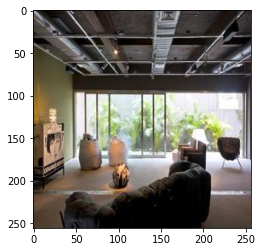

In [108]:
print('---- original -----')
plt.imshow(Ximg)

---- predict -----


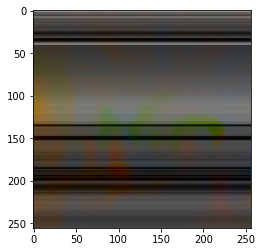

In [109]:
print('---- predict -----')
plt.imshow(rgbResult[0])

---- grayScale -----


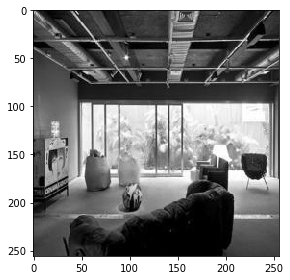

In [110]:
print('---- grayScale -----')
imshow(gray2rgb(rgb2gray(imread(fileName))))

In [58]:
for x in image_ds:
    print(x)

tf.Tensor(b'/content/gcImages/content/gc-dataset/train/0.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/10.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/100.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1001.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1002.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1003.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1004.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1005.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/gcImages/content/gc-dataset/train/1006.jpg', shape=(), dtype=string)
tf.Tensor(b'/conten